# Detecting Tumor on CT+MRI scans using ResNet
 

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random


**Download DataSet from Kaggle**


Image 1 Shape: (640, 640)
Image 2 Shape: (512, 512)
Image 3 Shape: (512, 512)
Image 4 Shape: (640, 640)
Image 5 Shape: (512, 512)


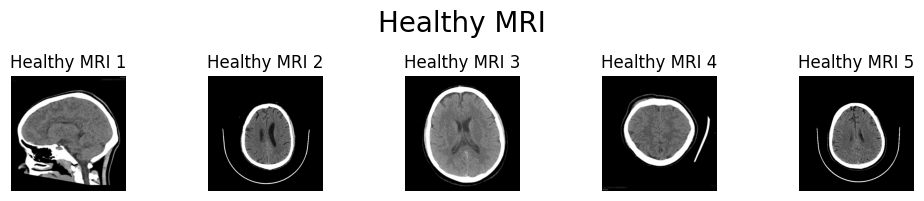

Image 1 Shape: (640, 640)
Image 2 Shape: (640, 640)
Image 3 Shape: (640, 640)
Image 4 Shape: (205, 255)
Image 5 Shape: (640, 640)


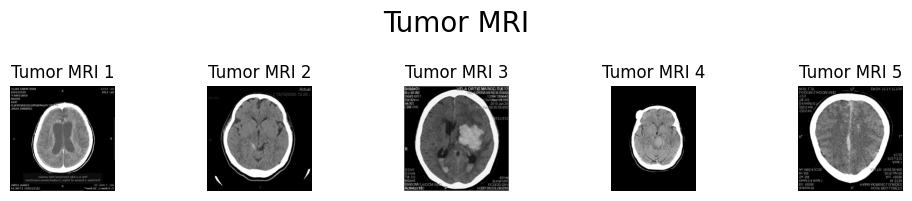

Image 1 Shape: (554, 554)
Image 2 Shape: (512, 512)
Image 3 Shape: (512, 512)
Image 4 Shape: (513, 522)
Image 5 Shape: (512, 512)


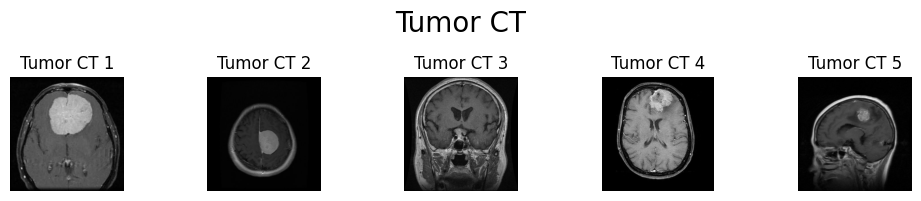

Image 1 Shape: (1024, 1024)
Image 2 Shape: (224, 224)
Image 3 Shape: (512, 512)
Image 4 Shape: (256, 256)
Image 5 Shape: (236, 260)


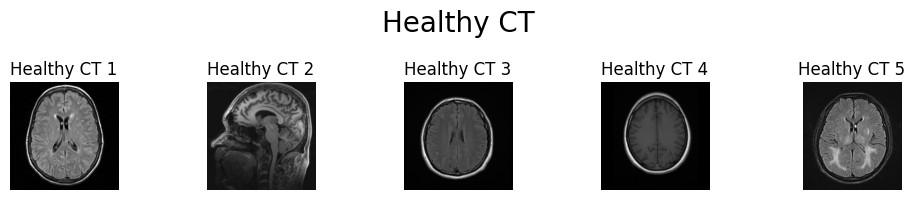

In [47]:
dataset_path = "Dataset"

mri_tumor_path = os.path.join(dataset_path, "Brain Tumor CT scan Images", "Tumor")
mri_healthy_path = os.path.join(dataset_path, "Brain Tumor CT scan Images", "Healthy")
ct_tumor_path = os.path.join(dataset_path, "Brain Tumor MRI Images", "Tumor")
ct_healthy_path = os.path.join(dataset_path, "Brain Tumor MRI Images", "Healthy")

def display_images_from_path(path, title="Images", num_images=5):
    images = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(('png', 'jpg', 'jpeg'))]
    plt.figure(figsize=(10, 2))
    plt.suptitle(title, fontsize=20)
    random_images = random.sample(images, min(num_images, len(images)))
    for i, image_path in enumerate(random_images):
        img = Image.open(image_path)  
        print(f"Image {i + 1} Shape: {img.size}")
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray') 
        plt.axis('off')
        plt.title(f"{title} {i + 1}")
    plt.tight_layout()
    plt.show()
print("")
display_images_from_path(mri_healthy_path, title="Healthy MRI")
display_images_from_path(mri_tumor_path, title="Tumor MRI")
display_images_from_path(ct_tumor_path, title="Tumor CT")
display_images_from_path(ct_healthy_path, title="Healthy CT")


**Prosses Images**

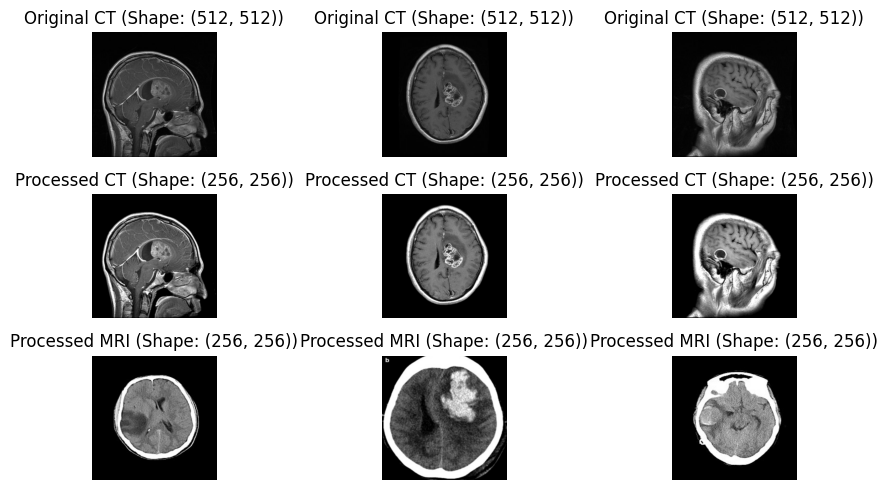

In [175]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import os

def adjust_image(image, brightness_factor=1.2, contrast_factor=1.5, size=(256, 256), sharpness_factor=1.5):
    image = image.convert("L")
    # Enhance brightness
    enhancer_brightness = ImageEnhance.Brightness(image)
    image = enhancer_brightness.enhance(brightness_factor)
    
    # Enhance contrast
    enhancer_contrast = ImageEnhance.Contrast(image)
    image = enhancer_contrast.enhance(contrast_factor)
    
    # Enhance sharpness
    enhancer_sharpness = ImageEnhance.Sharpness(image)
    image = enhancer_sharpness.enhance(sharpness_factor)
    
    # Resize image
    image = image.resize(size)
    return image

def preprocess_and_display(ct_path, mri_path, output_path, size=(256, 256), num_images=3, show_images=False):
    # Load CT and MRI images
    ct_images = [os.path.join(ct_path, f) for f in os.listdir(ct_path) if f.endswith(('png', 'jpg', 'jpeg'))]
    mri_images = [os.path.join(mri_path, f) for f in os.listdir(mri_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    # Process and save all images
    for i, image_path in enumerate(ct_images):
        with Image.open(image_path) as img:
            processed_img = adjust_image(img, size=size)
            processed_img.save(os.path.join(output_path, f"CT_Processed_{i}.png"), format='PNG')

    for i, image_path in enumerate(mri_images):
        with Image.open(image_path) as img:
            processed_img = adjust_image(img, brightness_factor=1, contrast_factor=1, size=size, sharpness_factor=1.5)
            processed_img.save(os.path.join(output_path, f"MRI_Processed_{i}.png"), format='PNG')

    if show_images:
        # Display CT Original and Processed
        plt.figure(figsize=(10, 5))
        for i in range(num_images):
            with Image.open(ct_images[i]) as ct_img:
                plt.subplot(3, num_images, i + 1)
                plt.imshow(ct_img, cmap='gray')
                plt.axis('off')
                plt.title(f"Original CT (Shape: {ct_img.size})")

            with Image.open(ct_images[i]) as ct_img:
                processed_ct_img = adjust_image(ct_img, size=size)
                plt.subplot(3, num_images, num_images + i + 1)
                plt.imshow(processed_ct_img, cmap='gray')
                plt.axis('off')
                plt.title(f"Processed CT (Shape: {size})")

        # Display MRI Processed
        for i in range(num_images):
            with Image.open(mri_images[i]) as mri_img:
                processed_mri_img = adjust_image(mri_img, brightness_factor=1, contrast_factor=1, size=size)
                plt.subplot(3, num_images, 2 * num_images + i + 1)
                plt.imshow(processed_mri_img, cmap='gray')
                plt.axis('off')
                plt.title(f"Processed MRI (Shape: {size})")

        plt.tight_layout()
        plt.show()

# Paths
output_pathT  = "Processed_Images/Tumor"
output_pathH = "Processed_Images/Healthy"

# Create output directory if it doesn't exist
os.makedirs(output_pathT, exist_ok=True)
os.makedirs(output_pathH, exist_ok=True)

# Call the function
preprocess_and_display(mri_tumor_path, ct_tumor_path, output_pathT, size=(256, 256), num_images=3, show_images=True)
preprocess_and_display(mri_healthy_path, ct_healthy_path, output_pathH, size=(256, 256), num_images=3, show_images=False)


**Split Train&Test&Validation**

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

processed_path = "Processed_Images"
output_base_path = "Dataset_Split"
subfolders = ['train', 'val', 'test']
categories = ['Healthy', 'Tumor']

# יצירת תקיות חדשות לחלוקה
for subfolder in subfolders:
    for category in categories:
        os.makedirs(os.path.join(output_base_path, subfolder, category), exist_ok=True)

# פונקציה לחלוקת התמונות
def split_and_copy_images(base_path, category_name, output_base_path, train_ratio=0.7, val_ratio=0.2):
    images = [os.path.join(base_path, f) for f in os.listdir(base_path) if f.endswith(('png', 'jpg', 'jpeg'))]
    train, temp = train_test_split(images, test_size=1 - train_ratio, random_state=42)
    val, test = train_test_split(temp, test_size=val_ratio / (1 - train_ratio), random_state=42)

    # העתקת תמונות לכל קבוצה
    for img_path in train:
        shutil.copy(img_path, os.path.join(output_base_path, 'train', category_name))
    for img_path in val:
        shutil.copy(img_path, os.path.join(output_base_path, 'val', category_name))
    for img_path in test:
        shutil.copy(img_path, os.path.join(output_base_path, 'test', category_name))

# חלוקה עבור כל קטגוריה
split_and_copy_images(os.path.join(processed_path, 'Healthy'), 'Healthy', output_base_path)
split_and_copy_images(os.path.join(processed_path, 'Tumor'), 'Tumor', output_base_path)

print("Dataset has been split into Train, Validation, and Test sets.")


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [9]:
import numpy as np

print("Numpy version:", np.__version__)
import sklearn
print("Scikit-learn version:", sklearn.__version__)


Numpy version: 2.2.1


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [7]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
